# Online Shoppers Purchasing Intention Analysis
https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset

# STEP 0 : Importing libraries and files

In [32]:
# Importing the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Importing the dataset
dataset = pd.read_csv("online_shoppers_intention.csv", header = 0)
print("Shape :", dataset.shape)

Shape : (12330, 18)


# STEP 1 : Data Cleaning

In [33]:
# Check if data cleaning is necessary
dataset.dtypes

Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

### Encoding categorical features

In [34]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
column_trans = make_column_transformer((OneHotEncoder(),['Month','OperatingSystems','Browser','VisitorType','Weekend']),remainder='passthrough')

In [35]:
dataset.shape

(12330, 18)

In [36]:
#dataset = pd.get_dummies(dataset,columns=['Month','OperatingSystems','Browser','VisitorType','Weekend'])

# STEP 2 : Data preprocessing

In [37]:
#Downsampling
from sklearn.utils import resample
dataset['Revenue'].value_counts()
#Purchased
dataset_p = dataset[dataset.Revenue==True]
#Not Purchased
dataset_np = dataset[dataset.Revenue==False]
#Downsampled Dataset
dataset_p_down = resample(dataset_p,replace=False,n_samples=1000)
dataset_np_down = resample(dataset_np,replace=False,n_samples=5000)
dataset = pd.concat([dataset_p_down,dataset_np_down])

### Creating training and testing set

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# Identifying the class label
X = dataset.drop(columns=['Revenue'])
column_trans.fit(X)
X = column_trans.transform(X)
scalar = MinMaxScaler()
scalar.fit(X)
y = dataset['Revenue']
# Spliting the dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=0)
# Center and normalize the data
X_train = scalar.transform(X_train)
X_test = scalar.transform(X_test)

In [39]:
X_train.shape

(4500, 48)

# STEP 3 : Data Visualisation

In [40]:
visualisation = pd.read_csv("online_shoppers_intention.csv", header = 0)
visu_p = dataset[dataset.Revenue==True] #Purchased
visu_np = dataset[dataset.Revenue==False] #Not Purchased
visu_p = resample(dataset_p,replace=False,n_samples=1900)
visu_np = resample(dataset_np,replace=False,n_samples=1900)

In [41]:
visu_p.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000
mean,3.398421,119.551910,0.788421,57.839001,48.231579,1876.413775,0.005123,0.019562,27.256103,0.023263,2.093684,2.456842,3.082105,4.026842
std,3.735981,201.183429,1.523373,171.943223,58.358375,2314.960583,0.012201,0.016481,35.252451,0.123772,0.930249,1.900010,2.410394,3.992597
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,15.000000,541.906250,0.000000,0.009521,3.586337,0.000000,2.000000,2.000000,1.000000,2.000000
50%,2.000000,52.450000,0.000000,0.000000,29.000000,1109.906250,0.000000,0.016059,16.735734,0.000000,2.000000,2.000000,2.000000,2.000000
75%,5.000000,151.391667,1.000000,19.000000,57.000000,2262.022024,0.006452,0.025000,38.847425,0.000000,2.000000,2.000000,4.000000,4.000000
max,26.000000,2086.750000,12.000000,1767.666667,534.000000,27009.859430,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


### Principal Component Analysis

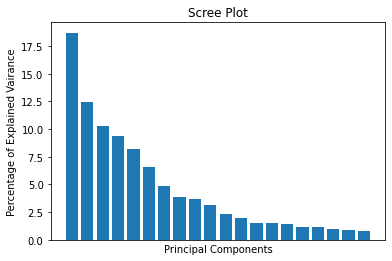

In [42]:
from sklearn import decomposition
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#Showing the first 20 most important axes
pca = PCA(n_components=20)

X_train_pca = pca.fit_transform(X_train)
per_var = np.round(pca.explained_variance_ratio_*100,decimals=1)
labels = [str(x) for x in range(1,len(per_var)+1)]
plt.bar(x=range(1,len(per_var)+1),height=per_var)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.ylabel('Percentage of Explained Vairance')
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.show()

### 3D PCA Plot

explained variance ratio (first three components): [0.18725347 0.12394587 0.10251201]


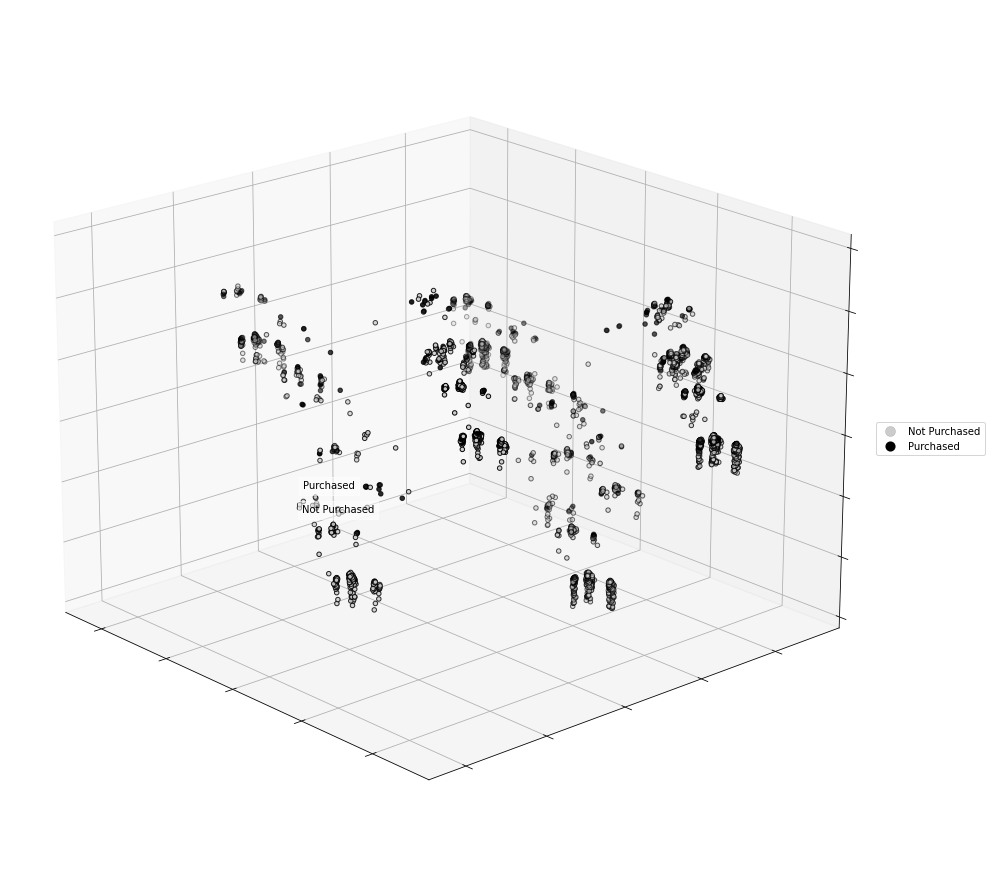

In [43]:
centers = [[1, 1], [-1, -1], [1, -1]]
X = X_train
y = y_train

fig = plt.figure(1, figsize=(16, 12))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=20, azim=138)

plt.cla()
pca = decomposition.PCA(n_components=3)
pca.fit(X)
X = pca.transform(X)
labelTups= [('Not Purchased', 0), ('Purchased', 1)]
for name, label in labelTups:
    ax.text3D(X[y == label, 0].mean(),
              X[y == label, 1].mean() + 1.5,
              X[y == label, 2].mean(), name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
# Reorder the labels to have colors matching the cluster results
y = np.choose(y, [1, 0]).astype(float)
sc =ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=plt.cm.nipy_spectral,
           edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

colors = [sc.cmap(sc.norm(i)) for i in [1, 0]]
custom_lines = [plt.Line2D([],[], ls="", marker='.', 
                mec='k', mfc=c, mew=.1, ms=20) for c in colors]
ax.legend(custom_lines, [lt[0] for lt in labelTups], 
          loc='center left', bbox_to_anchor=(1.0, .5))
# Percentage of variance explained for each components
print('explained variance ratio (first three components): %s'
      % str(pca.explained_variance_ratio_))
plt.show()

### 2D PCA Plot

explained variance ratio (first three components): [0.18725347 0.12394587 0.10251201]


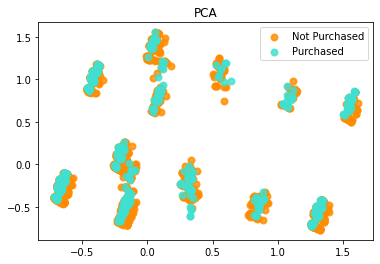

In [44]:
X_r = pca.fit(X_train).transform(X_train)

# Percentage of variance explained for each components
print('explained variance ratio (first three components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
colors = ['darkorange', 'turquoise']
lw = 2

target_names= ["Not Purchased","Purchased"]

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y_train == i, 0], X_r[y_train == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA')

plt.show()

### Bar plot

Returning_Visitor    5111
New_Visitor           836
Other                  53
Name: VisitorType, dtype: int64
False    5000
True     1000
Name: Revenue, dtype: int64


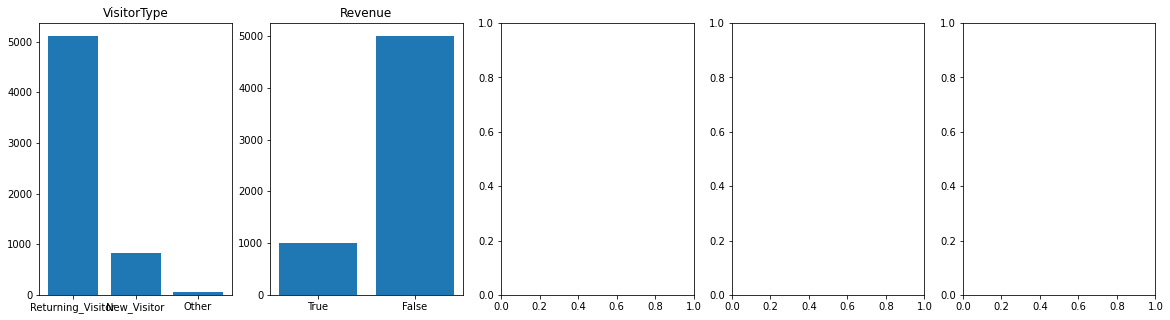

In [46]:
fig, axs = plt.subplots(1,5)
fig.set_size_inches(20,5)

axs[0].set_title("VisitorType")
print(dataset['VisitorType'].value_counts())
Vtype = ['Returning_Visitor','New_Visitor','Other']
count_vtype = [dataset['VisitorType'].value_counts()['Returning_Visitor'],dataset['VisitorType'].value_counts()['New_Visitor'],dataset['VisitorType'].value_counts()['Other']]
axs[0].bar(Vtype,count_vtype)

axs[1].set_title("Revenue")
print(dataset['Revenue'].value_counts())
TF = ["True","False"]
TF_count = [dataset['Revenue'].value_counts()[True],dataset['Revenue'].value_counts()[False]]
axs[1].bar(TF,TF_count)

plt.show()

# STEP 4: Building ML Model

In [47]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

## Overview of a few model's performance

Naive Bayes  Accuracy: 0.29733333333333334
Logistic Regression  Accuracy: 0.8726666666666667


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


K Nearest Neighbour  Accuracy: 0.8353333333333334
Support Vector Classification  Accuracy: 0.8466666666666667
Decision Tree Classification  Accuracy: 0.864
Stochastic Gradient Descent  Accuracy: 0.8853333333333333
Linear Discriminant Analysis  Accuracy: 0.8793333333333333
Gradiant Boosting Classification   Accuracy: 0.906
Random Forest Classification  Accuracy: 0.9


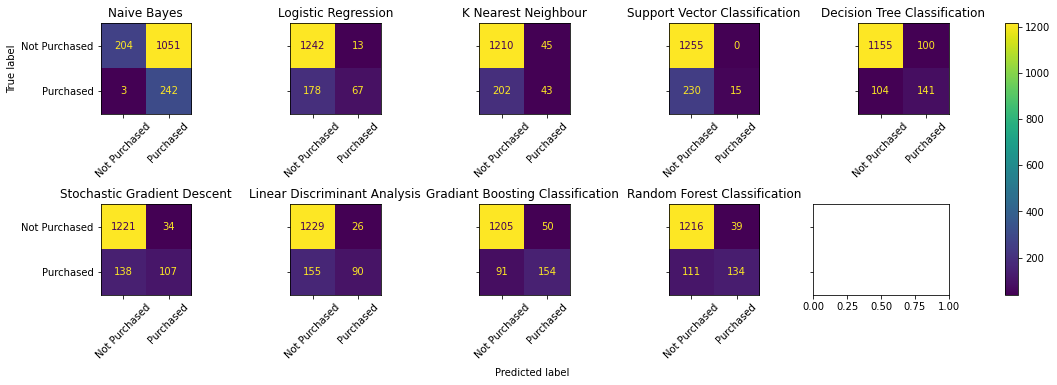

In [48]:
classifiers = {
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(),
    "K Nearest Neighbour": KNeighborsClassifier(),
    "Support Vector Classification": SVC(),
    "Decision Tree Classification": DecisionTreeClassifier(),
    "Stochastic Gradient Descent": SGDClassifier(),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    "Gradiant Boosting Classification ": GradientBoostingClassifier(),
    "Random Forest Classification": RandomForestClassifier()
}

f, axes = plt.subplots(2, 5, figsize=(20, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    j = 0
    k = i
    if i>4:
        k = i-5
        j+=1
    
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    print(key, " Accuracy:",accuracy_score(y_test,y_pred))
    disp = ConfusionMatrixDisplay(cf_matrix,
                                  display_labels=["Not Purchased","Purchased"])
    disp.plot(ax=axes[j][k], xticks_rotation=45)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.43, -0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=1)


f.colorbar(disp.im_, ax=axes)
plt.show()

# STEP 3 : Model Tuning (Grid Search)

### Gradiant Boosting

In [55]:
parameters = [{
    "loss":["deviance"],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 1,2),
    "min_samples_leaf": np.linspace(0.1, 0.5, 1,2),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5,0.8,0.9,1.0],
    "n_estimators":[10]
    }]
gbm = GridSearchCV(GradientBoostingClassifier(), parameters, cv=5, n_jobs=-1,scoring='accuracy', verbose=True)
gbm.fit(X_train,y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 755 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:  1.0min finished


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid=[{'criterion': ['friedman_mse', 'mae'],
                          'learning_rate': [0.01, 0.05, 0.1, 0.2],
                          'loss': ['deviance'], 'max_depth': [3, 5, 8],
                          'max_features': ['log2', 'sqrt'],
                          'min_samples_leaf': array([0.1]),
                          'min_samples_split': array([0.1]),
                          'n_estimators': [10],
                          'subsample': [0.5, 0.8, 0.9, 1.0]}],
             scoring='accuracy', verbose=True)

In [56]:
print(gbm.best_params_)

{'criterion': 'friedman_mse', 'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'n_estimators': 10, 'subsample': 1.0}


#### Gradient boosting with best parameters

In [87]:
gs_gbm = GradientBoostingClassifier( 
    criterion='friedman_mse',
    learning_rate=0.2,
    loss='deviance',
    max_depth=5,
    max_features='log2',
    min_samples_leaf= 0.1,
    min_samples_split= 0.1,
    n_estimators = 10,
    subsample = 1.0
)
gs_gbm.fit(X_train, y_train)
gs_gbm.score(X_test,y_test)

0.8433333333333334

In [88]:
gs_gbm = GradientBoostingClassifier( 
    criterion='friedman_mse',
    learning_rate=0.2,
    loss='deviance',
    max_depth=8,
    max_features='sqrt',
    min_samples_leaf= 0.1,
    min_samples_split= 0.1,
    n_estimators = 10,
    subsample = 1.0
)
gs_gbm.fit(X_train, y_train)
gs_gbm.score(X_test,y_test)

0.8573333333333333

## Stochastic gradiant descent

In [ ]:
parameters = [{
    "max_iter": [100000,150000,200000],
    "loss": ["hinge","log","squared_hinge","perceptron"],
    "penalty": ["elasticnet", "l1", "l2"],
    "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 
    "learning_rate": ['constant', 'optimal', 'invscaling', 'adaptive'],
    "class_weight": [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}],
    "eta0": [1, 10, 100] 
             }]
sgd = GridSearchCV(SGDClassifier(), parameters, cv=5, n_jobs=-1,scoring='accuracy', verbose=True)
sgd.fit(X_train,y_train)

Fitting 5 folds for each of 13824 candidates, totalling 69120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 664 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 1131 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 1510 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 2074 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 2976 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 4082 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 5441 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 6828 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 8664 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 10676 tasks      | elapsed: 20.3min


In [ ]:
print(sgd.best_params_)

#### Stochastic gradient descent with best parameters

In [102]:
gs_sgd = SGDClassifier(alpha =0.001, 
                       class_weight ={1: 0.7, 0: 0.3}, 
                       eta0 =1, 
                       learning_rate = 'optimal', 
                       loss= 'hinge', 
                       max_iter=10000000, 
                       penalty= 'l2')
gs_sgd.fit(X_train, y_train)
gs_sgd.score(X_test,y_test)

0.8706666666666667

### Random Forest

In [ ]:
parameters = [{
    "n_estimators": [100, 500,1000],
    "max_features": ['auto', 'sqrt'],
    "max_depth": [5, 50, 100],
    "min_samples_split": [2, 50,100], 
    "min_samples_leaf": [1,5, 10],
    "bootstrap": [True, False]
             }]

rf = GridSearchCV(RandomForestClassifier(), parameters, cv=5, n_jobs=-1,scoring='accuracy', verbose=True)
rf.fit(X_train,y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    8.0s


In [163]:
print(rf.best_params_)

{'bootstrap': False, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 100, 'n_estimators': 100}


#### Random forest with best parameters

In [73]:
gs_rf = RandomForestClassifier(bootstrap=False, 
                               max_depth= 50, 
                               max_features='sqrt', 
                               min_samples_leaf=1, 
                               min_samples_split=100, 
                               n_estimators=100)
gs_rf.fit(X_train, y_train)
gs_rf.score(X_test,y_test)

0.8833333333333333

### DecisionTree

In [ ]:
parameters = [{
    "criterion": ['gini','entropy'],
    "max_depth": range(1,10),
    "min_samples_split": range(1,10), 
    "min_samples_leaf": range(1,5),
             }]

dt = GridSearchCV(DecisionTreeClassifier(), parameters, cv=5, n_jobs=-1,scoring='accuracy', verbose=True)
dt.fit(X_train,y_train)

In [ ]:
print(dt.best_params_)

In [ ]:
gs_dt = DecisionTreeClassifier(bootstrap=False, 
                               max_depth= 50, 
                               max_features='sqrt', 
                               min_samples_leaf=1, 
                               min_samples_split=100, 
                               n_estimators=100)
gs_rf.fit(X_train, y_train)
gs_rf.score(X_test,y_test)

# STEP 4 : Ensemble Model Building

### Side by side comparison with the 5 best performing classifiers (Confusion matrices)

Logistic Regression  Accuracy: 0.8806666666666667
Support Vector Machine  Accuracy: 0.8806666666666667
Stochastic Gradiant Descent  Accuracy: 0.884
Random Forest  Accuracy: 0.8833333333333333


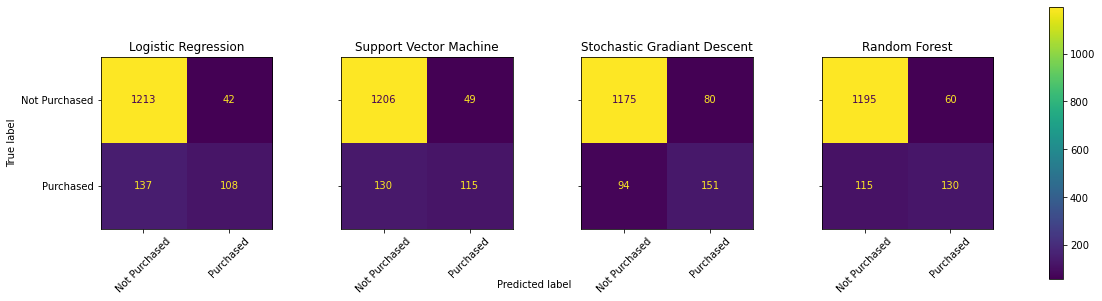

In [74]:
classifiers = {
    "Logistic Regression": gs_lr,
    "Support Vector Machine": gs_svm,
    "Stochastic Gradiant Descent": gs_sgd,
    "Random Forest": gs_rf
}

f, axes = plt.subplots(1, 4, figsize=(20, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    print(key, " Accuracy:",accuracy_score(y_test,y_pred))
    disp = ConfusionMatrixDisplay(cf_matrix,
                                  display_labels=["Not Purchased","Purchased"])
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)


f.colorbar(disp.im_, ax=axes)
plt.show()

# STEP 5 : Results

## Combination of the best 4 models 

In [75]:
from sklearn.ensemble import VotingClassifier
estimators=[('lr', gs_lr), ('svm', gs_svm),('sgd',gs_sgd),('rf',gs_rf)]
ensemble = VotingClassifier(estimators, voting='hard')

ensemble.fit(X_train, y_train)
ensemble.score(X_test, y_test)

0.8853333333333333

In [1]:
import pickle
pickle.dump(ensemble, open('Flask_restful_api/model.pickle', 'wb'))
pickle.dump(scalar, open('Flask_restful_api/scaler.pickle','wb'))
pickle.dump(column_trans, open('Flask_restful_api/column_trans.pickle','wb'))

NameError: name 'ensemble' is not defined